In [1]:
import re, string
from unidecode import unidecode

PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation))

class Fingerprinter(object):
    '''
    Python implementation of Google Refine fingerprinting algorithm described here:
    https://github.com/OpenRefine/OpenRefine/wiki/Clustering-In-Depth
    Requires the unidecode module: https://github.com/iki/unidecode
    '''
    def __init__(self, string):
        self.string = self._preprocess(string)

    def _preprocess(self, string):
        '''
        Strip leading and trailing whitespace, lowercase the string, remove all punctuation,
        in that order.
        '''
        return PUNCTUATION.sub('', string.strip().lower())

    def _latinize(self, string):
        '''
        Replaces unicode characters with closest Latin equivalent. For example,
        Alejandro González Iñárritu becomes Alejando Gonzalez Inarritu.
        '''
        return unidecode(string)

    def _unique_preserving_order(self, seq):
        '''
        Returns unique tokens in a list, preserving order. Fastest version found in this
        exercise: http://www.peterbe.com/plog/uniqifiers-benchmark
        '''
        seen = set()
        seen_add = seen.add
        return [x for x in seq if not (x in seen or seen_add(x))]
        
    def get_fingerprint(self):
        '''
        Gets conventional fingerpint.
        '''
        return self._latinize(' '.join(
            self._unique_preserving_order(
                sorted(self.string.split())
            )
        ))

    def get_ngram_fingerprint(self, n=1):
        '''
        Gets ngram fingerpint based on n-length shingles of the string.
        Default is 1.
        '''
        return self._latinize(''.join(
            self._unique_preserving_order(
                sorted([self.string[i:i + n] for i in range(len(self.string) - n + 1)])
            )
        ))

In [2]:
import numpy as np
import pandas as pd

import pandasql

pd.set_option('display.max_rows', 500)

In [8]:
metadata = pd.read_json("./data/metadata_oi.json")
metadata.head()

,canonical_id,category_type,genre_list,series_name,episode_name,season_number,episode_number,content_length_ms,genre_primary,series_premiere,season_premiere,original_name,description,image_url16x9,image_url4x3,actors_list,awards_list
0,1342a8c6baaf8a9c9ef8109d2f42e0cfa1aa2a571d1154...,SERIES,Crime,Amor Assassino,Drama Policial,6,2,3600000,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,156d34c040aff2ab831bcf06fc5d49e064ee735abe7dee...,SERIES,Crime,Amor Assassino,Drama Policial,0,0,2631000,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,19ec84d3110abb2db190b0f0a80f029358ac9721b39b40...,SERIES,Crime,Amor Assassino,Segredos e Mentiras,6,1,3600000,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
3,1bcfae9394416d4cc508597e953d1d9e47e39a2ee9df9e...,SERIES,Crime,Assassinos de Beleza,Pecados Capitais,2,4,2640000,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,1c78e45194332187bd57b21ba0536d66511f868889ad59...,SERIES,Crime,Assassinos de Beleza,Obsessão Fatal,1,2,2640000,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [9]:
def refine_text(refine_text_column, metadata, algorithm):
        fp_raw_table = pd.DataFrame()
        fp_raw_table[refine_text_column] = metadata[refine_text_column]
        
        if algorithm == "fingerprint": 
            fp_raw_table['fingerprint'] = metadata[refine_text_column].apply(lambda x: Fingerprinter(x).get_fingerprint())
        elif algorithm == "ngram-fingerprint":
            fp_raw_table['fingerprint'] = metadata[refine_text_column].apply(lambda x: Fingerprinter(x).get_ngram_fingerprint())
        else: return 0
    
        fp_table = pandasql.sqldf(("SELECT DISTINCT \
                first_value({0}) OVER (PARTITION BY fingerprint ORDER BY ct) as {1}_refined, \
                {2}, \
                first_value(fingerprint) OVER (PARTITION BY fingerprint ORDER BY ct) as fingerprint \
               from \
               (select {3}, fingerprint, length({4}) ct from fp_raw_table group by 1, 2)  \
               ").format(refine_text_column, refine_text_column, refine_text_column, refine_text_column, refine_text_column))
        
        print("disambuation histgram:")
        mergedf = pandasql.sqldf(("select a.ct as merge_number, count(1) ct from (select fingerprint, count(distinct {}) ct from fp_raw_table group by 1)a group by 1 order by 1 asc").format(refine_text_column))
        ax = mergedf.plot.bar(x='merge_number', y='ct', rot=0)
        
        return pandasql.sqldf(("select metadata.*, fp_table.{}_refined from metadata left join fp_table on metadata.{} = fp_table.{}").format(refine_text_column, refine_text_column, refine_text_column))               

# Text Refine

disambuation histgram:


,series_name,series_name_refined
233,Carol - Carol,Carol
261,Valente - Valente,Valente
266,12 Horas - 12 Horas,12 Horas
270,Bayern TV - Bayern TV,Bayern TV
279,Empire State - Empire State,Empire State
290,Futebol na Veia - Futebol na Veia,Futebol na Veia
293,A Grande Escolha - A Grande Escolha,A Grande Escolha
294,Bate-Bola Debate - Bate-Bola Debate,Bate-Bola Debate
295,Bolt - Supercão - Bolt - Supercão,Bolt - Supercão
303,Campeonato Espanhol - Campeonato Espanhol,Campeonato Espanhol


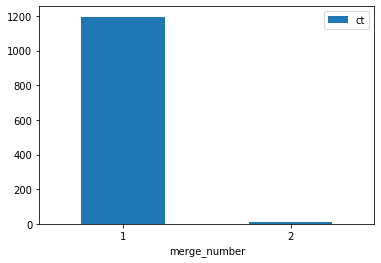

In [10]:
refine_text_column = 'series_name'
algorithm = 'fingerprint' # fingerprint, ngram-fingerprint

metadata = refine_text(refine_text_column, metadata, algorithm)

metadata[metadata[refine_text_column] != metadata[refine_text_column + '_refined']][[refine_text_column, refine_text_column + '_refined']]

disambuation histgram:


,episode_name,episode_name_refined
109,Duelo de Titãs - Duelo de Titãs,Duelo de Titãs
110,Duelo de Titãs - Duelo de Titãs,Duelo de Titãs
112,A Grande Escolha - A Grande Escolha,A Grande Escolha
113,A Grande Escolha - A Grande Escolha,A Grande Escolha
116,Bem-Vindo à Vida - Bem-Vindo à Vida,Bem-Vindo à Vida
118,Bem-Vindo à Vida - Bem-Vindo à Vida,Bem-Vindo à Vida
123,Me Chama de Bruna - Me Chama de Bruna,Me Chama de Bruna
124,O Caminho de Volta - O Caminho de Volta,O Caminho de Volta
131,Conspiração e Poder - Conspiração e Poder,Conspiração e Poder
132,Conspiração e Poder - Conspiração e Poder,Conspiração e Poder


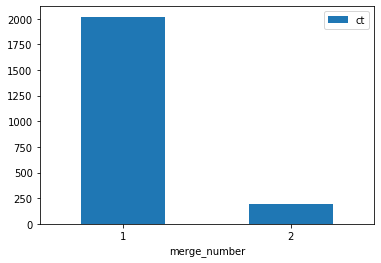

In [11]:
refine_text_column = 'episode_name'
algorithm = 'fingerprint' # fingerprint, ngram-fingerprint

metadata = refine_text(refine_text_column, metadata, algorithm)

metadata[metadata[refine_text_column] != metadata[refine_text_column + '_refined']][[refine_text_column, refine_text_column + '_refined']]